In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import statistics
from sklearn.neighbors import KNeighborsRegressor
import tqdm
import pickle

Определим все функции, которыми будем пользоваться в дальнейшем.

In [2]:
def cross_validation(model,n_fold, n_splits, X, y):
  models = [ ]
  scores = [ ]
  for i in range(n_fold):
     kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)

     for num, (train_index, test_index) in enumerate(kf.split(X)):
       X_train, X_test = X.iloc[train_index], X.iloc[test_index]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]

       model.fit(X_train, y_train)

       models.append(model)

       y_pred = model.predict(X_test)
       score = np.sqrt(mse(y_pred, y_test))
       scores.append(score)

       #print(f"fold: {num} rmse: {score}")
  print("total rmse", np.mean(scores, dtype="float16"), 'std',  np.std(scores).round(4))

  return models


def cross_pred(model, X):
  pred = pd.DataFrame()
  for n, est in enumerate(model):
    pred[n]= est.predict(X)
  pred['mean'] = pred.mean(axis = 1)
  return pred['mean']


def cuped(control, test, control_ml, test_ml):
    theta = (statistics.covariance(control - test, control_ml - test_ml) / np.var(control_ml - test_ml))

    control_cup = control - theta * (control_ml - np.mean(control_ml))
    test_cup = test - theta * (test_ml - np.mean(test_ml))
    
    return control_cup, test_cup


def no_plot_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
):
    df_1 = int(len(data_column_1) - 1)
    df_2 = int(len(data_column_2) - 1)
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
      
    p_1 = stats.t.cdf(
        df = df_1,
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.t.cdf(
        df =df_2,
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return min(p_1, p_2) * 2, quants


def bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
):
    df_1 = int(len(data_column_1) - 1)
    df_2 = int(len(data_column_2) - 1)
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
      
    p_1 = stats.t.cdf(
        df = df_1,
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.t.cdf(
        df =df_2,
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    plt.vlines(quants,ymin=0,ymax=10,linestyle='--', color = 'blue')
    plt.hist(boot_data)
    plt.xlabel('boot_data', color = 'black')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return min(p_1, p_2) * 2, quants, statistics.mode(boot_data)


def corr_test_control(control, test):
    corr_table = pd.DataFrame()
    
    for name in control.drop(['Campaign Name', 'Date'], axis = 1).columns:
        corr_table[name] = [statistics.correlation(test[name], control[name]), \
                            statistics.covariance(test[name], control[name])]
        
    corr_table.rename(index = {0 : 'corr', 1 : 'cov'}, inplace = True)
    return corr_table

In [3]:
test = pd.read_csv('test_group.csv', sep = ',')
control = pd.read_csv('control_group.csv')

In [4]:
print('Тестовая выборка')
test.sample(4)

Тестовая выборка


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
27,Test Campaign,28.08.2019,2247,54627,41267,8144,2432,1281,1009,721
14,Test Campaign,15.08.2019,2516,94338,76219,4993,2537,1609,1090,398
28,Test Campaign,29.08.2019,2805,67444,43219,7651,1920,1240,1168,677
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677


In [5]:
print('Контрольная выборка')
control.sample(4)

Контрольная выборка


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
21,Control Campaign,22.08.2019,2939,105705.0,86218.0,6843.0,3102.0,2988.0,819.0,387.0
18,Control Campaign,19.08.2019,2596,107890.0,81268.0,3706.0,2483.0,2098.0,908.0,542.0
26,Control Campaign,27.08.2019,2061,104678.0,91579.0,4941.0,3549.0,3249.0,980.0,605.0
16,Control Campaign,17.08.2019,2177,119612.0,106518.0,6628.0,1756.0,1642.0,878.0,222.0


Создамим колонку с расчитанной метрикой Average Purchase Per User, посчитав как количество покупок 
к переходу на сайт

In [6]:
test['ARPU'] = test['# of Purchase'] / test['# of Website Clicks']
control['ARPU'] = control['# of Purchase'] / control['# of Website Clicks']

Заполнил пропуски медианной по датасету

In [7]:
imp =  SimpleImputer(missing_values=np.nan, strategy='median')
control[[x for x in control.columns if control[x].dtype != 'object']] = imp.fit_transform(control.drop(['Campaign Name','Date'], axis = 1))

In [ ]:
Корреляционная таблица между характеристикой из теста с аналогичной из контроля. Как видно, данные слабо 
коррелируют, что говорит о независимости выборок.

In [8]:
corr_test_control(control, test)

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,ARPU
corr,-0.056525,-2.410187e-02,8.527324e-03,-0.014654,0.062737,0.066518,-0.015033,0.108981,-0.027928
cov,-7239.960920,-1.650827e+07,5.269138e+06,-43237.747126,20768.997701,30374.724138,-2092.406897,4182.673563,-0.000084


In [9]:
sns.set_style("whitegrid")
sns.set_context("notebook")

Гистограммы контроля и теста

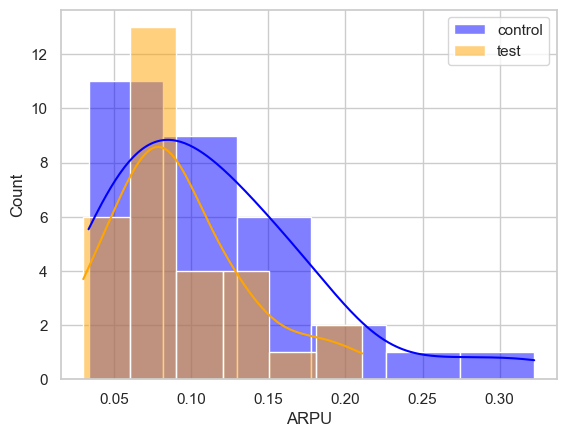

In [10]:
sns.histplot(data=control, x="ARPU", kde=True, color = 'blue', label = 'control')
sns.histplot(data=test, x="ARPU", kde=True, color = 'orange',label = 'test')
plt.legend()

In [ ]:
Боксплоты среднего и контроля. Из них видно, что у наших данных высокая дисперсия, а так же есть выбросы.

<Axes: xlabel='Campaign Name', ylabel='ARPU'>

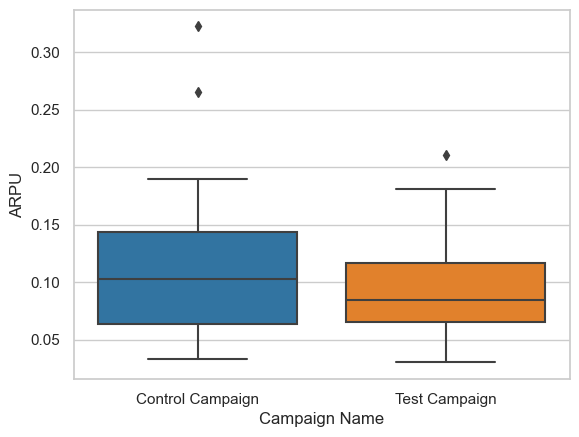

In [11]:
sns.boxplot(data=pd.concat([control, test],axis=0), y = 'ARPU', x = 'Campaign Name')

Посмотрим вобщем на данные, как они взаимодействуют друг с другом и на их распределения.

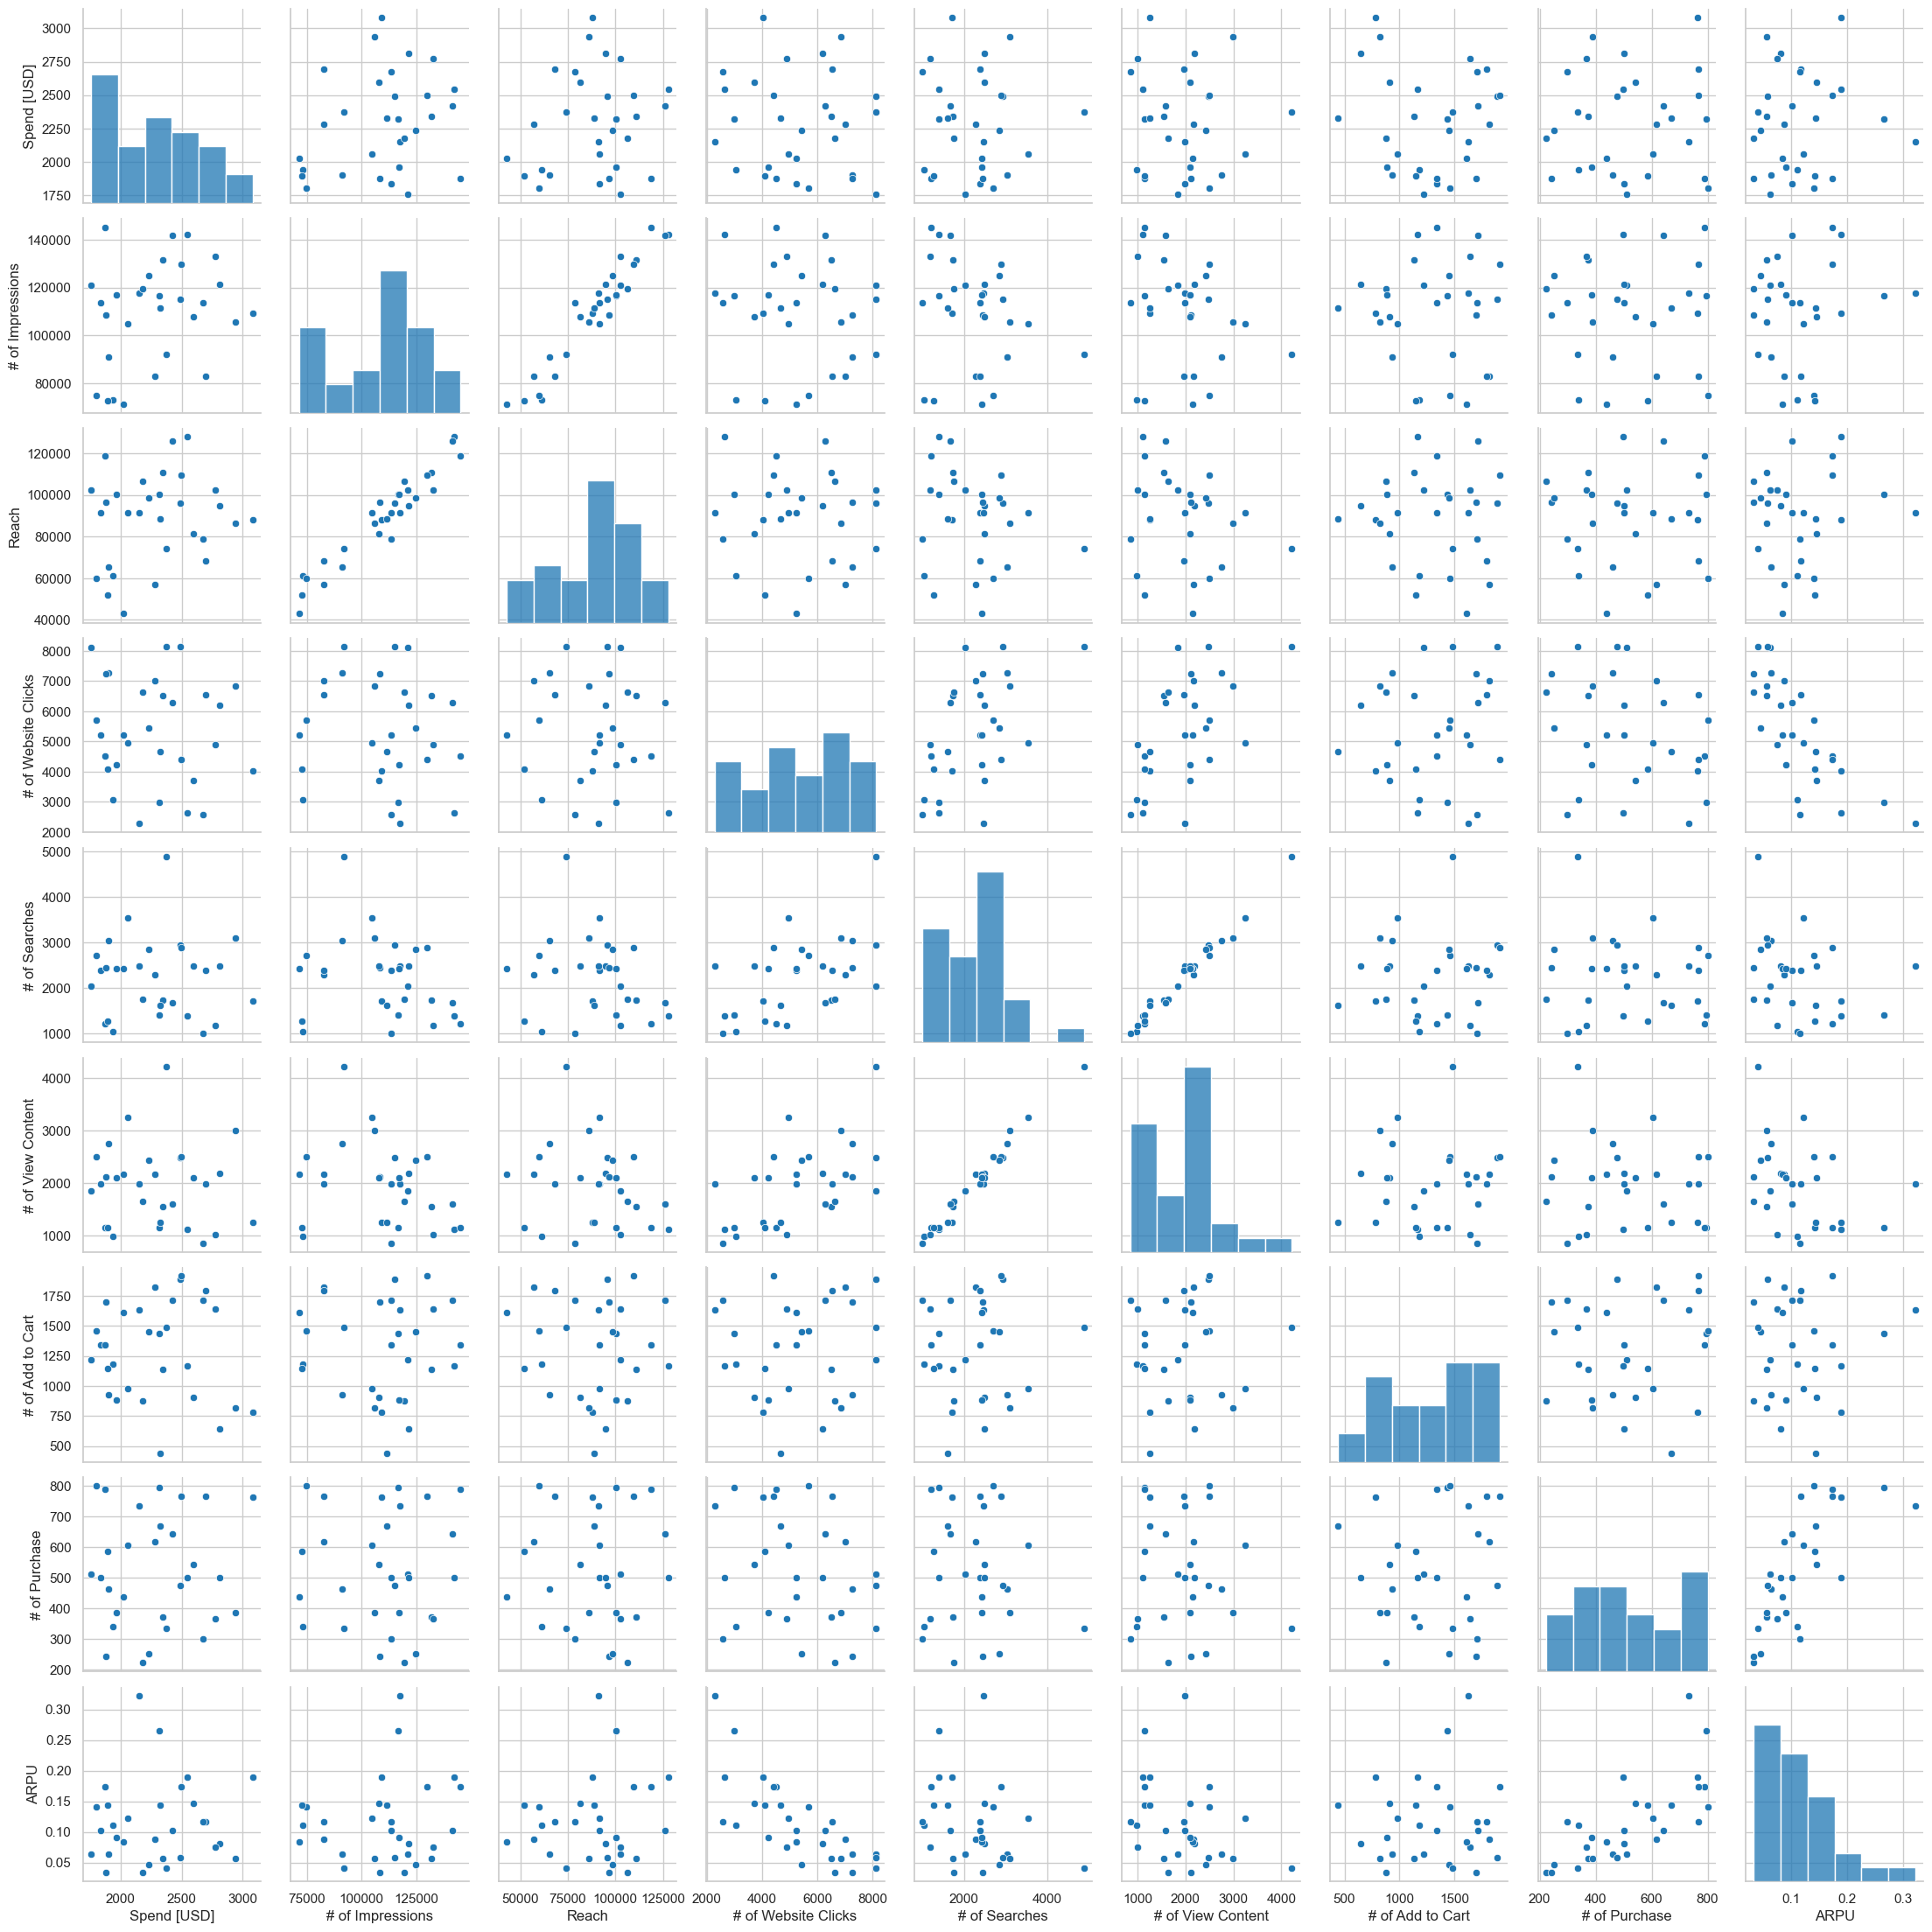

In [12]:
cols = [x for x in control.columns if control[x].dtype != 'object']
sns.pairplot(control[cols])

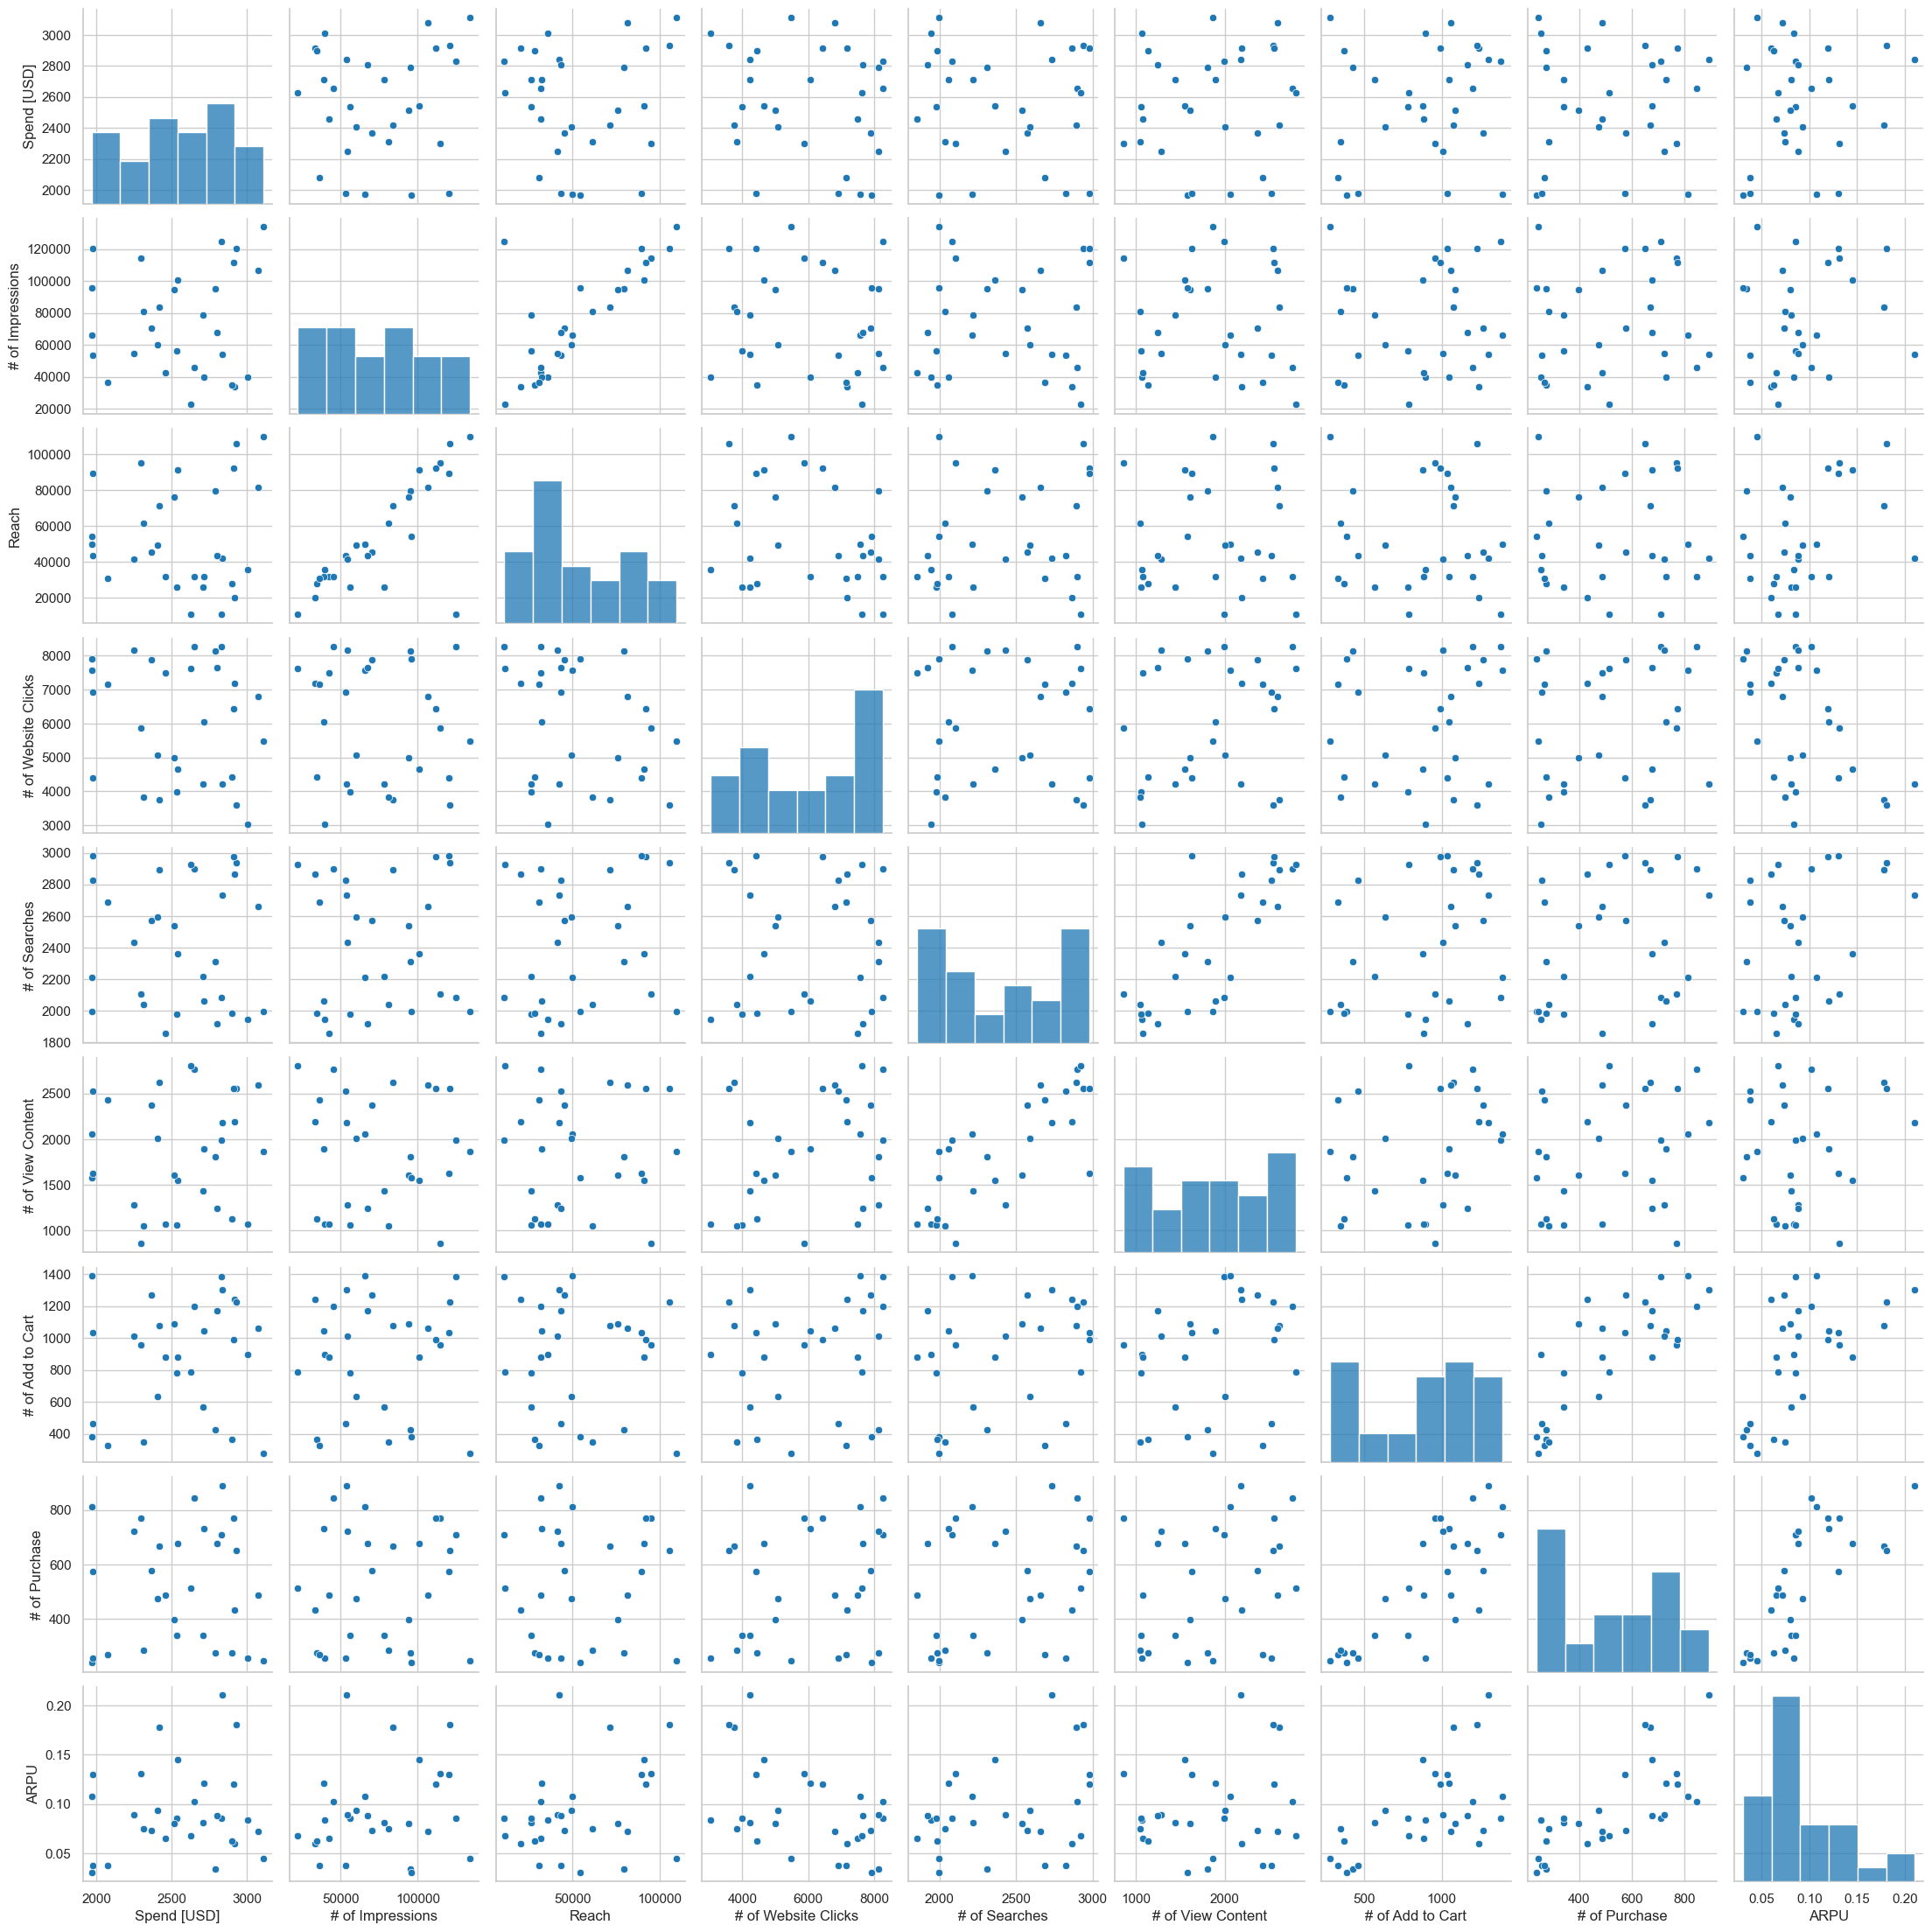

In [13]:
cols = [x for x in test.columns if test[x].dtype != 'object']
sns.pairplot(test[cols])

По qq-plot видно, что данные далеки от нормальных

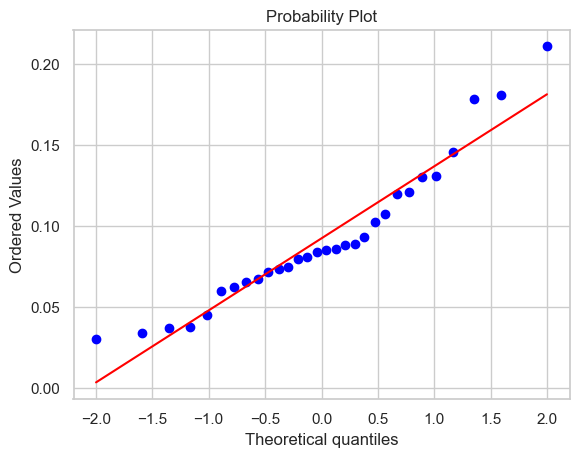

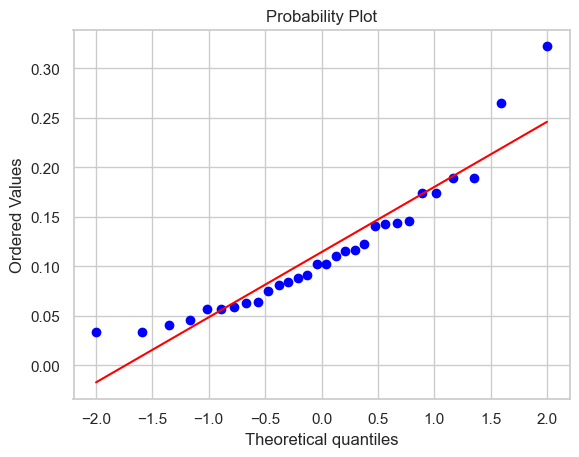

In [14]:
stats.probplot(test['ARPU'], dist='norm', plot=plt)
plt.show()
stats.probplot(control['ARPU'], dist='norm', plot=plt)
plt.show()

Тест Шапиро так же говорит о ненормальности данных

In [15]:
W_val, p_val = stats.shapiro(test['ARPU'])
print('test : ', round(W_val, 2), round(p_val,3))
W_val, p_val = stats.shapiro(control['ARPU'])
print('control : ', round(W_val,2), round(p_val,3))

test :  0.93 0.037
control :  0.89 0.006


Чтобы уменьшить дисперсию провел cuped с помощью случайного леса обученного на контроле.

In [16]:
drop_col = ['Campaign Name', 'Date']

In [17]:
data = control.drop(drop_col, axis = 1)

Обучал на данных, которые наиболее коррелируют в тесте и контроле, из предположения, что именно они являются определяющими

In [18]:
X_cols = ['# of View Content', '# of Purchase', 'Spend [USD]', '# of Searches']
X = data[X_cols]
y = data['ARPU']

In [19]:
# model = cross_validation(RandomForestRegressor(verbose = 0), 1, 5, X, y)
# pred = cross_pred(model, X)
# print('точность модели : rmse', round(np.sqrt(mse(y, pred)),3))

Код обучения модели выше. Но так как представление во многом зависит от модели, оптимальную я загрузил и далее использовал только ее

In [20]:
model = pickle.load(open('finalized_model.sav', 'rb'))
pred = cross_pred(model, X)
print('точность модели : rmse', round(np.sqrt(mse(y, pred)),3))

точность модели : rmse 0.031


Как видно среднее теста и контроля ml модели достаточно близки к среднему контроля эксперимента.

In [21]:
contr_model = control[X_cols]
test_model = test[X_cols]
control_ml = cross_pred(model,contr_model)
test_ml = cross_pred(model, test_model)
print('Среднее теста и контроля ml модели :\n', round(np.mean(test_ml),3), round(np.mean(control_ml),3))
control_cup, test_cup = cuped(control.ARPU, test.ARPU, control_ml, test_ml)

Среднее теста и контроля ml модели :
 0.117 0.115


Как видно по боксплотам и по посчитанным дисперсиям данные стали менее шумными. А из гистограмм видно, что они могут подчинятся t распределению.

In [22]:
print('Среднее начального теста и контроля', round(np.mean(test.ARPU),3), round(np.mean(control.ARPU),3))
print('После cuped', round(np.mean(test_cup),3), round(np.mean(control_cup),3))

Среднее начального теста и контроля 0.092 0.114
После cuped 0.092 0.114


In [23]:
print('Дисперсия начального тест и контроля', round(np.var(test.ARPU),4), round(np.var(control.ARPU),4))
print('После cuped', round(np.var(test_cup), 4), round(np.var(control_cup), 4))

Дисперсия начального тест и контроля 0.0019 0.0044
После cuped 0.0016 0.0011


In [24]:
control['cup'], test['cup'] = control_cup, test_cup

<Axes: xlabel='Campaign Name', ylabel='cup'>

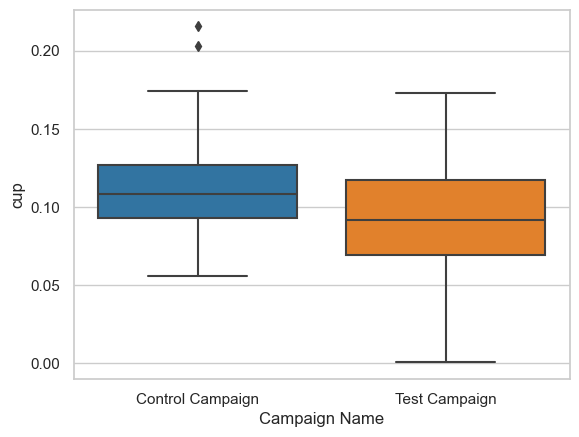

In [25]:
sns.boxplot(data=pd.concat([control, test],axis=0), y = 'cup', x = 'Campaign Name')

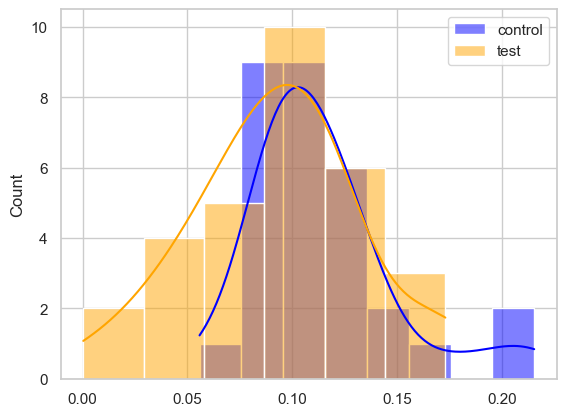

In [26]:
sns.histplot(data=control_cup,  kde=True, color = 'blue', label = 'control')
sns.histplot(data=test_cup, kde=True, color = 'orange',label = 'test')
plt.legend()

Но из qq-plot и Шапиро по прежнему следует, что данные не являются нормальными

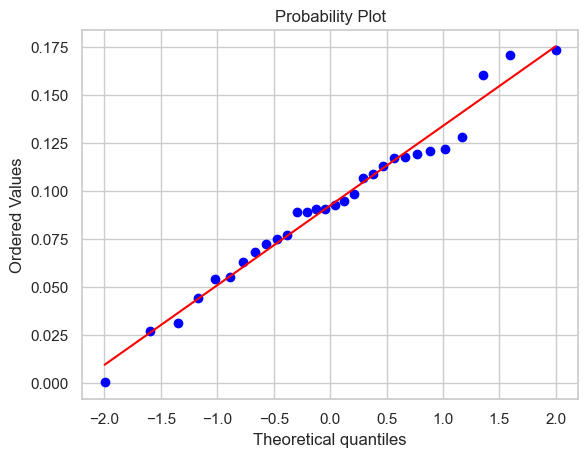

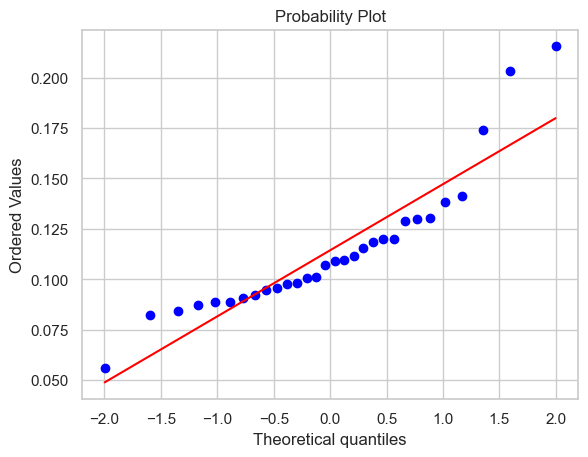

In [27]:
stats.probplot(test_cup, dist='norm', plot=plt)
plt.show()
stats.probplot(control_cup, dist='norm', plot=plt)
plt.show()

In [28]:
W_val, p_val = stats.shapiro(test_cup)
print('test : ', round(W_val,2), round(p_val,2))
W_val, p_val = stats.shapiro(control_cup)
print('control : ', round(W_val,2), round(p_val,4))

test :  0.98 0.8
control :  0.86 0.0011


Проводим A/A тест для бутстрапа

In [39]:
p_value, quants = no_plot_bootstrap(control_cup, control_cup, boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(p_value,2)))

Статистическая значимость 0.97


In [40]:
print('Ошибка первого рода бутстрапа = {}'.format(round(1 - float(p_value),2)))

Ошибка первого рода бутстрапа = 0.03


Посчитаем ошибку второго рода

In [41]:
p_value, quants = no_plot_bootstrap(control_cup, test_cup, boot_it=10000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Ошибка второго рода бутстрапа {}'.format(round(p_value,2)))

Ошибка второго рода бутстрапа 0.03


In [ ]:
Проведем A/B тест. Как видно принимается альтернативная гипотеза. Ниже представлен график
распределения разницы средних.

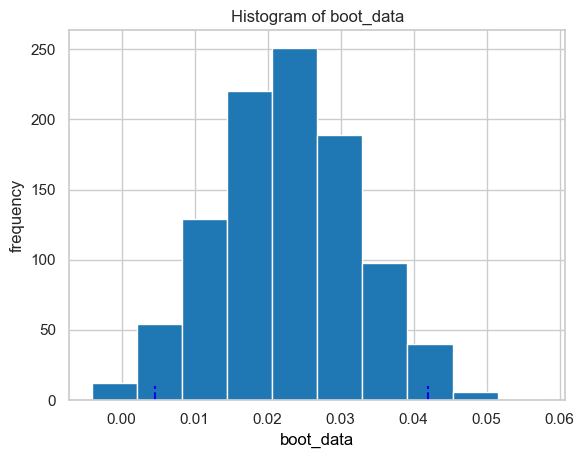

Статистическая значимость 0.024


In [42]:
p_value, quant, mode = bootstrap(control_cup, test_cup, boot_it=1000, statistic = np.mean, bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(np.mean(p_value), 3)))

In [43]:
print('95% доверительный интервал в разнице средних = ', round(quants.iloc[0][0], 3), round(quants.iloc[1][0],3))

95% доверительный интервал в разнице средних =  0.003 0.041


Проведем A/A тест для t теста

In [44]:
p_value = []
for i in range(10000):
    data_1, data_2 = control_cup.sample(30, replace = True), control_cup.sample(30, replace = True)
    t, p = stats.ttest_ind(data_1, data_2, equal_var=False, alternative = 'greater') 
    if p > 0.05:
        p_value.append(0)
    else:
        p_value.append(1)
p_mean = np.mean(p_value)
print('Ошибка первого рода t-test = {}'.format(round(p_mean,2)))

Ошибка первого рода t-test = 0.05


Посчитаем ошибку второго рода

In [45]:
p_value = []
for i in range(10000):
    data_1, data_2 = control_cup.sample(30, replace = True), test_cup.sample(30, replace = True)
    t, p = stats.ttest_ind(data_1, data_2, equal_var=False, alternative = 'greater') 
    if p >= 0.05:
        p_value.append(1)
    else:
        p_value.append(0)
beta = p_mean = np.mean(p_value)
print('Ошибка второго рода t-test = {}'.format(round(p_mean,2)))

Ошибка второго рода t-test = 0.24


Проведем A/B тест. Как видно, он тоже подтверждает альтернативную гипотезу.

In [46]:
t, p = stats.ttest_ind(control_cup, test_cup, equal_var=False, alternative = 'greater')
print('p_value t-test = {}'.format(round(p,3)))

p_value t-test = 0.013


Выведем основные статистики.

In [47]:
alpha = 0.95
all_ARPU = pd.concat([test_cup, control_cup], axis = 0)
std_all = np.std(all_ARPU)
n = len(all_ARPU)
z = scipy.stats.t.ppf(alpha, n - 1)
mde = np.sqrt(z ** 2 * std_all ** 2 / n)
print('Ошибка первого рода = {}'.format(0.05))
print('Ошибка второго рода = {}'.format(round(beta,2)))
print('Минимальный детектируемый эффект = {}'.format(round(mde,3)))
print('Доверительный интервал разницы средних посчитанной бутстрапом = ',\
      round(quants.iloc[0][0],3),'-',round(quants.iloc[1][0],3))
print('Мода разницы средних посчитанной бутстрапом = ', round(mode,3))

Ошибка первого рода = 0.05
Ошибка второго рода = 0.24
Минимальный детектируемый эффект = 0.008
Доверительный интервал разницы средних посчитанной бутстрапом =  0.003 - 0.041
Мода разницы средних посчитанной бутстрапом =  0.032
